In [1]:
import sys
sys.path.insert(0, './yolov5')
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from IPython.display import display, Image
import ipywidgets.widgets as widgets
import warnings
warnings.filterwarnings(action='ignore')

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path, save_one_box
from utils.plots import colors, plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized

In [2]:
set_logging()
device = torch.device('cuda')
weights = "best.pt"
imgsz = 640
# Load model
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(imgsz, s=stride)  # check img_size
names = model.module.names if hasattr(model, 'module') else model.names  # get class names

source = "0" #webcam
cudnn.benchmark = True  # set True to speed up constant image size inference
dataset = LoadStreams(source, img_size=imgsz, stride=stride)

model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
print("model load done")

Fusing layers... 
Model Summary: 224 layers, 7064698 parameters, 0 gradients


1/1: 0...  success (inf frames 640x480 at 30.00 FPS)

model load done


In [3]:
video = cv2.VideoCapture(0)
video.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
video.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

False

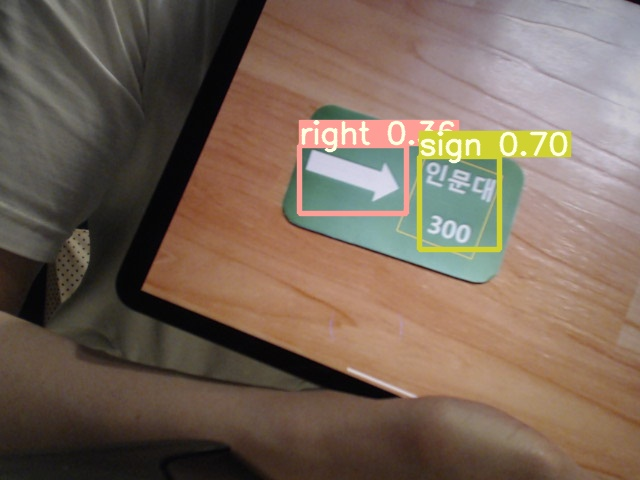

In [9]:
display_handle=display(None, display_id=True)

t0 = time.time()
try:
    for path, img, im0s, vid_cap in dataset:
        #_, img = video.read()
        img = torch.from_numpy(img).to(device)
        img = img.float()#img.half() #if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment='store_true')[0]

        # Apply NMS
        pred = non_max_suppression(pred, 0.3, 0.45, None, 'store_true',max_det=5)
        t2 = time_synchronized()

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            p, s, im0, frame = path[i], f'{i}: ', im0s[i].copy(), dataset.count

            p = Path(p)  # to Path
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
                
                for *xyxy, conf, cls in reversed(det):
                    c = int(cls)  # integer class
                    label = f'{names[c]} {conf:.2f}'
                    plot_one_box(xyxy, im0, label=label, color=colors(c, True), line_thickness=3)

        # Stream results
        _, frame = cv2.imencode('.jpg', im0)
        display_handle.update(Image(data=frame.tostring()))
        cv2.waitKey(10)  # 1 millisecond
except KeyboardInterrupt:
    pass
finally:
    video.release()

In [4]:
import sys
sys.path.insert(0, './ocr_kor/deep-text-recognition-benchmark')
import string
import argparse

import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch.nn.functional as F

from utils_ocr import CTCLabelConverter, AttnLabelConverter
from dataset import AlignCollate
from model import Model

In [25]:
class opt:
    saved_model = "RARE.pth"
    batch_size=192
    batch_max_length=50
    imgH = 32
    imgW=400
    sensitive=True
    Transformation='TPS'
    FeatureExtraction='VGG'
    SequenceModeling='BiLSTM'
    Prediction='Attn'
    character = '가각간갇갈감갑값갓강갖같갚갛개객걀걔거걱건걷걸검겁것겉게겨격겪견결겹경곁계고곡곤곧골곰곱곳공과관광괜괴굉교구국군굳굴굵굶굽궁권귀귓규균귤그극근글긁금급긋긍기긴길김깅깊까깍깎깐깔깜깝깡깥깨꺼꺾껌껍껏껑께껴꼬꼭꼴꼼꼽꽂꽃꽉꽤꾸꾼꿀꿈뀌끄끈끊끌끓끔끗끝끼낌나낙낚난날낡남납낫낭낮낯낱낳내냄냇냉냐냥너넉넌널넓넘넣네넥넷녀녁년념녕노녹논놀놈농높놓놔뇌뇨누눈눕뉘뉴늄느늑는늘늙능늦늬니닐님다닥닦단닫달닭닮담답닷당닿대댁댐댓더덕던덜덟덤덥덧덩덮데델도독돈돌돕돗동돼되된두둑둘둠둡둥뒤뒷드득든듣들듬듭듯등디딩딪따딱딴딸땀땅때땜떠떡떤떨떻떼또똑뚜뚫뚱뛰뜨뜩뜯뜰뜻띄라락란람랍랑랗래랜램랫략량러럭런럴럼럽럿렁렇레렉렌려력련렬렵령례로록론롬롭롯료루룩룹룻뤄류륙률륭르른름릇릎리릭린림립릿링마막만많말맑맘맙맛망맞맡맣매맥맨맵맺머먹먼멀멈멋멍멎메멘멩며면멸명몇모목몬몰몸몹못몽묘무묵묶문묻물뭄뭇뭐뭘뭣므미민믿밀밉밌및밑바박밖반받발밝밟밤밥방밭배백뱀뱃뱉버번벌범법벗베벤벨벼벽변별볍병볕보복볶본볼봄봇봉뵈뵙부북분불붉붐붓붕붙뷰브븐블비빌빔빗빚빛빠빡빨빵빼뺏뺨뻐뻔뻗뼈뼉뽑뿌뿐쁘쁨사삭산살삶삼삿상새색샌생샤서석섞선설섬섭섯성세섹센셈셋셔션소속손솔솜솟송솥쇄쇠쇼수숙순숟술숨숫숭숲쉬쉰쉽슈스슨슬슴습슷승시식신싣실싫심십싯싱싶싸싹싼쌀쌍쌓써썩썰썹쎄쏘쏟쑤쓰쓴쓸씀씌씨씩씬씹씻아악안앉않알앓암압앗앙앞애액앨야약얀얄얇양얕얗얘어억언얹얻얼엄업없엇엉엊엌엎에엔엘여역연열엷염엽엿영옆예옛오옥온올옮옳옷옹와완왕왜왠외왼요욕용우욱운울움웃웅워원월웨웬위윗유육율으윽은을음응의이익인일읽잃임입잇있잊잎자작잔잖잘잠잡잣장잦재쟁쟤저적전절젊점접젓정젖제젠젯져조족존졸좀좁종좋좌죄주죽준줄줌줍중쥐즈즉즌즐즘증지직진질짐집짓징짙짚짜짝짧째쨌쩌쩍쩐쩔쩜쪽쫓쭈쭉찌찍찢차착찬찮찰참찻창찾채책챔챙처척천철첩첫청체쳐초촉촌촛총촬최추축춘출춤춥춧충취츠측츰층치칙친칠침칫칭카칸칼캄캐캠커컨컬컴컵컷케켓켜코콘콜콤콩쾌쿄쿠퀴크큰클큼키킬타탁탄탈탑탓탕태택탤터턱턴털텅테텍텔템토톤톨톱통퇴투툴툼퉁튀튜트특튼튿틀틈티틱팀팅파팎판팔팝패팩팬퍼퍽페펜펴편펼평폐포폭폰표푸푹풀품풍퓨프플픔피픽필핏핑하학한할함합항해핵핸햄햇행향허헌험헤헬혀현혈협형혜호혹혼홀홈홉홍화확환활황회획횟횡효후훈훌훔훨휘휴흉흐흑흔흘흙흡흥흩희흰히힘'
    converter = AttnLabelConverter(character)
    num_class = len(converter.character)
    num_fiducial=20
    input_channel=1
    output_channel=512
    hidden_size=256
    rgb = True

In [26]:
ocr_model = Model(opt)
print('model input parameters:', opt.imgH, opt.imgW, opt.num_fiducial, opt.input_channel, opt.output_channel,
          opt.hidden_size, opt.num_class, opt.batch_max_length, opt.Transformation, opt.FeatureExtraction,
          opt.SequenceModeling, opt.Prediction)
device = torch.device('cuda')
ocr_model = torch.nn.DataParallel(ocr_model).to(device)
# load model

print('loading pretrained model from %s' % opt.saved_model)
ocr_model.load_state_dict(torch.load(opt.saved_model))


model input parameters: 32 400 20 1 512 256 974 50 TPS VGG BiLSTM Attn
loading pretrained model from RARE.pth


Exception ignored in: <bound method _ConnectionBase.__del__ of <multiprocessing.connection.Connection object at 0x7f097bbb38>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


<All keys matched successfully>

In [35]:
def ocr(img):
    # prepare data. two demo images from https://github.com/bgshih/crnn#run-demo
    AlignCollate_demo = AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=False)
    demo_loader = torch.utils.data.DataLoader(
        (img,), batch_size=opt.batch_size,
        shuffle=False,num_workers=4,
        collate_fn=AlignCollate_demo, pin_memory=True)

    # predict
    ocr_model.eval()
    for image_tensors, image_path_list in demo_loader:
        batch_size = image_tensors.size(0)
        with torch.no_grad():
            image = image_tensors.to(device)
            # For max length prediction
            length_for_pred = torch.cuda.IntTensor([opt.batch_max_length] * batch_size)
            text_for_pred = torch.cuda.LongTensor(batch_size, opt.batch_max_length + 1).fill_(0)
            
        preds = ocr_model(image, text_for_pred, is_train=False)

        # select max probabilty (greedy decoding) then decode index to character
        _, preds_index = preds.max(2)
        preds_str = converter.decode(preds_index, length_for_pred)

        for img_name, pred in zip(image_path_list, preds_str):
            pred = pred[:pred.find('[s]')]  # prune after "end of sentence" token ([s])
        
    return pred
            #print(f'{img_name}\t{pred}')

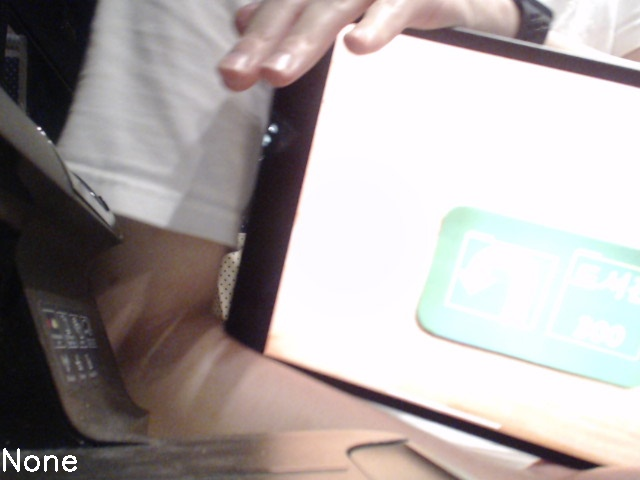

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/hyuk/.local/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/hyuk/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "./ocr_kor/deep-text-recognition-benchmark/dataset.py", line 273, in __call__
    images, labels = zip(*batch)
ValueError: too many values to unpack (expected 2)


In [36]:
display_handle=display(None, display_id=True)
show_res = 'None'
t0 = time.time()
try:
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.float()#img.half() #if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment='store_true')[0]

        # Apply NMS
        pred = non_max_suppression(pred, 0.3, 0.45, None, 'store_true',max_det=5)
        t2 = time_synchronized()

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            p, s, im0, frame = path[i], f'{i}: ', im0s[i].copy(), dataset.count

            p = Path(p)  # to Path
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
                
                for *xyxy, conf, cls in reversed(det):
                    c = int(cls)  # integer class
                    label = f'{names[c]} {conf:.2f}'
                    plot_one_box(xyxy, im0, label=label, color=colors(c, True), line_thickness=3)
                    if c == 4:
                        ocr_img = im0[int(xyxy[1]): int(xyxy[3]), int(xyxy[0]): int(xyxy[2])]
                        #show_res = ocr_model(ocr_img,torch.cuda.LongTensor(ocr_img.size(0), opt.batch_max_length + 1).fill_(0), is_train=False)
                        show_res = ocr(ocr_img)

        # Stream results
        cv2.putText(im0, '%s' %(show_res),(0,470), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        _, frame = cv2.imencode('.jpg', im0)
        #_, frame = cv2.imencode('.jpg', ocr_img)
        display_handle.update(Image(data=frame.tostring()))
        cv2.waitKey(100)  # 100 millisecond
except KeyboardInterrupt:
    pass
finally:
    video.release()